In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

project_path = "/content/drive/MyDrive/MSc/Research/Sentiment_Emotion_Intelligence/"
dataset_path = os.path.join(project_path, "dataset/Product Reviews - Emotion.csv")

# Create directories if not exist
os.makedirs(project_path, exist_ok=True)

print("Project directory:", project_path)

Project directory: /content/drive/MyDrive/MSc/Research/Sentiment_Emotion_Intelligence/


### Load the Data

In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv(dataset_path, encoding='utf-8')
print(df.shape)
df.head()

(23978, 5)


,Review,Rating,Sentiment,Emotion,Category
0,"The product is just awesome, anyone can go for...",4,Positive,Excitement,Electronics
1,Does not say ribbed. did not want ribbed. woul...,1,Negative,Anger,Bottoms
2,Shoddy stitching. Seams uneven.,1,Negative,Anger,Tops
3,These batteries work but don't really last tha...,1,Negative,Sadness,Health & Beauty
4,The dress was pretty but the pattern on the ma...,3,Negative,Sadness,Dresses & Suits


In [ ]:
# data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23978 entries, 0 to 23977
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     23978 non-null  object
 1   Rating     23978 non-null  int64 
 2   Sentiment  23978 non-null  object
 3   Emotion    23978 non-null  object
 4   Category   23978 non-null  object
dtypes: int64(1), object(4)
memory usage: 936.8+ KB


### Data Preprocessing

In [ ]:
import re
import contractions
from bs4 import BeautifulSoup
import nltk
from warnings import filterwarnings

filterwarnings('ignore')

In [ ]:
# Download resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# Expand Contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove HTML Tags
def remove_html(text):
    return BeautifulSoup(text, "html.parser").get_text()

# Normalize Clothing Sizes
def normalize_clothing_sizes(text):
    # Convert height in feet/inches to cm (approximate)
    pattern = re.compile(r"(\d)'\s?(\d{1,2})\"?")
    def convert(match):
        feet = int(match.group(1))
        inches = int(match.group(2))
        cm = round((feet * 12 + inches) * 2.54)
        return f"{cm} cm"
    return pattern.sub(convert, text)

# Remove URLs
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text)

# Remove Special Characters (but keep alphabets and category terms)
def remove_special_chars(text):
    # Keep: letters, digits, whitespace, and key emotional punctuation: ! ? . , : ; ' " - ...
    text = re.sub(r"[^A-Za-z0-9\s.,!?;:'\"-]", '', text)
    return text

# Normalize Whitespace & Line Breaks
def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

In [ ]:
# Data Cleaning Pipeline
def clean_review_emotion(text):
    if pd.isnull(text) or not isinstance(text, str):
        return ""

    text = expand_contractions(text)
    text = remove_html(text)
    text = normalize_clothing_sizes(text)
    text = remove_urls(text)
    text = remove_special_chars(text)
    text = normalize_whitespace(text)

    return text

In [ ]:
# Apply Data Cleaning
df['Cleaned_Reviews'] = df['Review'].apply(clean_review_emotion)
print(df.shape)
df.head()

(23978, 6)


,Review,Rating,Sentiment,Emotion,Category,Cleaned_Reviews
0,"The product is just awesome, anyone can go for...",4,Positive,Excitement,Electronics,"The product is just awesome, anyone can go for..."
1,Does not say ribbed. did not want ribbed. woul...,1,Negative,Anger,Bottoms,Does not say ribbed. did not want ribbed. woul...
2,Shoddy stitching. Seams uneven.,1,Negative,Anger,Tops,Shoddy stitching. Seams uneven.
3,These batteries work but don't really last tha...,1,Negative,Sadness,Health & Beauty,These batteries work but do not really last th...
4,The dress was pretty but the pattern on the ma...,3,Negative,Sadness,Dresses & Suits,The dress was pretty but the pattern on the ma...


### Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['Emotion'])

print("Train Dataset: ", train_df.shape[0])
print("Testing Dataset: ", test_df.shape[0])

Train Dataset:  21580
Testing Dataset:  2398


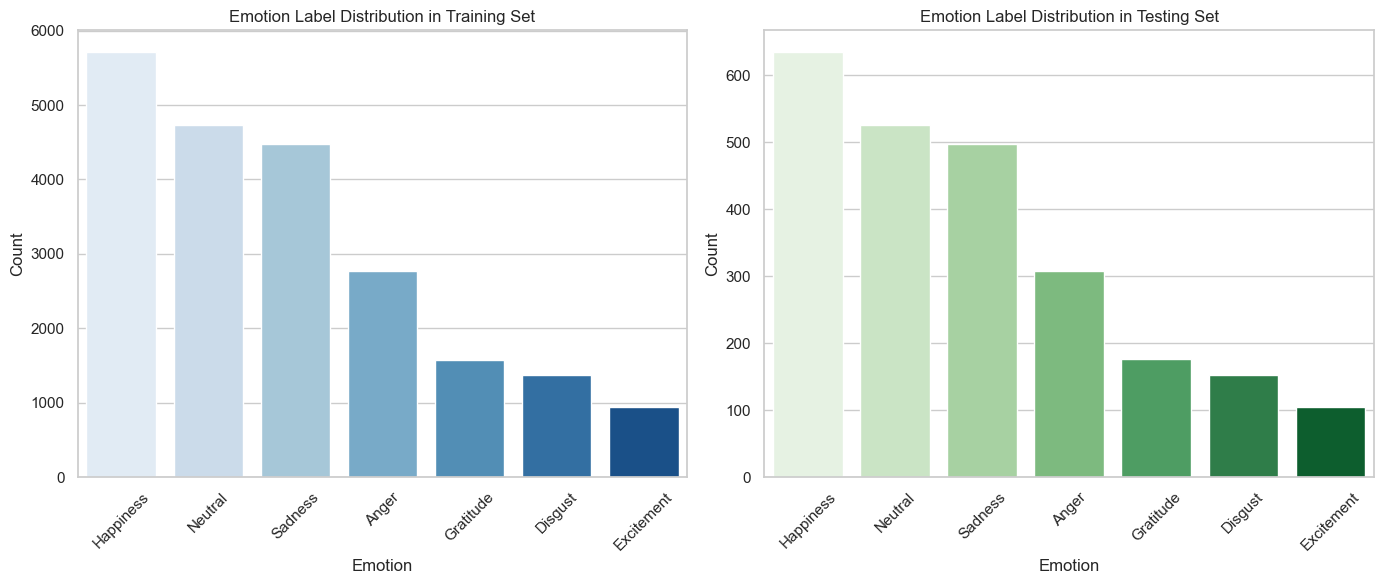

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Create a 1x2 subplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot training distribution
sns.countplot(ax=axes[0], x='Emotion', data=train_df, order=train_df['Emotion'].value_counts().index, palette='Blues')
axes[0].set_title("Emotion Label Distribution in Training Set")
axes[0].set_xlabel("Emotion")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

# Plot testing distribution
sns.countplot(ax=axes[1], x='Emotion', data=test_df, order=test_df['Emotion'].value_counts().index, palette='Greens')
axes[1].set_title("Emotion Label Distribution in Testing Set")
axes[1].set_xlabel("Emotion")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Embed & Store Training Data into Astra DB Vector Store

In [ ]:
import os
from langchain_astradb import AstraDBVectorStore
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document

In [ ]:
# HuggingFace embeddings
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

In [ ]:
# Format training data for vector store
documents = [
    Document(
        page_content=row['Cleaned_Reviews'],
        metadata={"emotion": row['Emotion']}
    )
    # for _, row in train_df.iterrows()
    for _, row in test_df.iterrows()
]

In [ ]:
documents[:10]

[Document(metadata={'emotion': 'Sadness'}, page_content='Nice product. Sizes def too small and arms were way too short'),
 Document(metadata={'emotion': 'Sadness'}, page_content='I did not realize it had a tie around the waist. it seems too much material hanging in the front to tie at the waist. unfortunately the sash is attached and cannot be removed. it is very cute; just not for me. i will have to return but sure i can find something else!'),
 Document(metadata={'emotion': 'Neutral'}, page_content='Pros:-Price point--cannot really go wrong-Clean signal no self-noise-Works for a tunerCons:-For recording or amplification purposes, this thing picks up a LOT of attack noise--fingers dropping on the strings, bow clicks, etc.-Additionally, the clamp does not always solidly grasp the instrument, and shakes around a bit. God help you if you touch the pickup while playing amplified.'),
 Document(metadata={'emotion': 'Gratitude'}, page_content='I bought this for my granddaughter she will be 2

In [ ]:
# Setup API Keys
from dotenv import load_dotenv

load_dotenv()

ASTRA_DB_API_ENDPOINT = os.getenv('ASTRA_DB_API_ENDPOINT')
ASTRA_DB_APPLICATION_TOKEN = os.getenv('ASTRA_DB_APPLICATION_TOKEN')
ASTRA_DB_KEYSPACE = os.getenv('ASTRA_DB_KEYSPACE')

GROQ_API_KEY = os.getenv("GROQ_API_KEY")

In [ ]:
# Connect to Astra DB
vector_store = AstraDBVectorStore(
    embedding=embedding_model,
    collection_name="emotion_reviews",
    api_endpoint=ASTRA_DB_API_ENDPOINT,
    token=ASTRA_DB_APPLICATION_TOKEN,
    namespace=ASTRA_DB_KEYSPACE
)

# Insert training data into Astra vector DB
vector_store.add_documents(documents)

['31507ccdbec44c8cb0933557a0a3a14a',
 'e95a8a226d2543d3a0b39ca5b0c56a73',
 '61b5c698975c4058a1b4354951882556',
 'a8eb66bca4834bc69c02b622e667e8b8',
 '781612103e0e4a7b95dca283a40a7223',
 'd27a6ce12fda49638ce9a6d7571a620a',
 '5ddcc8fd1ff54f50bb3c4c8981d6033b',
 '59dbad41d90f4c8dbb1e0a08de2e81ff',
 '9145f1cf331e4682ad882cc3f3249589',
 'efa9fb19dd37487191ed89267850558b',
 '0841c03e5c77424ba051660d835dedb5',
 'e65ae5fcd9524886a0f5ccdd7e669407',
 '251464f1bc3a46b5802765ca5d41bd74',
 '4853702552ba4f32a46257cb0224e7b7',
 '139963dd687441ab849ee08ae49fd4cf',
 'd8df54155e6644ec9a6fe5ee55c853f3',
 'be2d6cb156674ef7ae0c27b3466bed67',
 '8e3d6c5010d243369694e4bf5c5b483f',
 'b0150373335346d6a079fd8062d14e63',
 'f87b8bcd8fb24df5969420eeb6bf7dd8',
 '0dc89adddb644532adde89bae9548fc4',
 'f4ba148b07314363b5b6b5785128c90f',
 'e602bffe28c243faa8bc1ef0d26dae6d',
 'e44c2ca110f04e2a93dde2d12bad31dc',
 '2fa7b4c198b44e2b982825ca179fdda6',
 'e3181e2c14f740249c418b5b909ba5c8',
 '4904f7d71dbf44ceaa0353d41cdb4eef',
 

### Define the Prompt Template

In [ ]:
from langchain.prompts import PromptTemplate

emotion_prompt = PromptTemplate.from_template(
"""
You are an expert Emotion Classifier for e-commerce product reviews.
Your task is to read the user review and classify the **dominant emotion** expressed. You will also receive 10 most similar reviews with known labels for reference.

🧠 Choose **only one emotion** from:
`Happiness`, `Excitement`, `Gratitude`, `Anger`, `Sadness`, `Disgust`, `Neutral`

📌 Key emotion cues:

1. **Happiness**
   - Indicates positive, pleasant, and fulfilling experiences. Commonly reflects joy, contentment, satisfaction, or delight.
   - e.g., "Love this", "Nice and useful", "Very pleased", "It works perfectly, I love it"

2. **Excitement**
   - Shows heightened arousal, enthusiasm, eagerness, or amazement. Often associated with anticipation or overjoyed reactions.
   - e.g., "AMAZING!", "Can't wait", "Blew my mind!", "Can't wait", "Super thrilled", "LOVE IT", "Sooo good, blew my mind",

3. **Gratitude**
   - Communicates appreciation, acknowledgment, or thankfulness toward the product or service.
   - e.g., "Thanks", "Grateful", "Appreciate this", "Highly recommend - thank you!".

4. **Anger**
   - Expresses strong dissatisfaction, frustration, irritation, annoyance, blame, or confrontational tone.
   - e.g., "Worst ever", "Unacceptable", "Furious", "So annoying", "I'm very upset with this product", "Terrible service — I'm furious", "Poor delivery and rude staff"

5. **Sadness**
   - Reflects emotional disappointment, regret, dissatisfaction, sorrow, or letdown.
   - e.g., "Disappointed", "Expected better", "Let down", "Disheartened".

6. **Disgust**
   - Indicates revulsion, repulsion, or moral/sensory violation. Includes unhygienic or offensive qualities.
   - e.g., "Smells awful", "Disgusting", "Gross item", "Shameful service", "Offensive behavior", "Gross and dirty item", "Made me feel sick".

7. **Neutral**
   - Factual, emotionless, or balanced statements without strong sentiment. Includes functional reviews, comparisons, or generic comments.
   - e.g., "Fine for price", "It works", "The product works as expected" , "Does the job", "Product as described", "Average quality but usable".

📝 Review tone, punctuation (!, caps), intensifiers (e.g., "SO good"), emojis (😍, 🤮), and context.

⚠️ If mixed sentiment, use the **dominant emotional tone**.
- Calm + positive → Happiness
- Energetic + positive → Excitement
- Thanking → Gratitude
- Emotional regret → Sadness
- Moral/sensory offense → Disgust
- Blame/tone → Anger
- Polite/function-only → Neutral

🎯 Output only:
Emotion: <one of 7>
Confidence: <0.00 - 1.00> (reflecting clarity, tone, and context)

### Review:
{review}

### Similar Reviews:
{similar_reviews}

"""
)

In [ ]:
# Setup LLM
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama3-70b-8192", temperature=0.3, api_key=GROQ_API_KEY)

### RAG Inference Function

In [ ]:
from langchain.chains import LLMChain
from tqdm import tqdm
import re

def extract_emotion_and_confidence(output):
    try:
        emotion_match = re.search(r"Emotion:\s*(\w+)", output)
        conf_match = re.search(r"Confidence:\s*([\d.]+)", output)
        emotion = emotion_match.group(1)
        confidence = float(conf_match.group(1))
    except:
        emotion, confidence = "Unknown", 0.0
    return emotion, confidence

llm_chain = LLMChain(prompt=emotion_prompt, llm=llm)

In [ ]:
test_1 = test_df.iloc[:500]
print("Test Set 1: ", test_1.shape)

test_2 = test_df.iloc[500:1000]
print("Test Set 2: ", test_2.shape)

test_3 = test_df.iloc[1000:1500]
print("Test Set 3: ", test_3.shape)

test_4 = test_df.iloc[1500:2000]
print("Test Set 4: ", test_4.shape)

test_5 = test_df.iloc[2000:]
print("Test Set 5: ", test_5.shape)

Test Set 1:  (500, 6)
Test Set 2:  (500, 6)
Test Set 3:  (500, 6)
Test Set 4:  (500, 6)
Test Set 5:  (398, 6)


In [ ]:
import time

# Testing the model
y_true = []
y_pred = []

for index, row in tqdm(test_5.iterrows(), total=len(test_5)):
    review = row['Cleaned_Reviews']
    true_emotion = row['Emotion']
    y_true.append(true_emotion)

    # Search in vector DB
    results = vector_store.similarity_search_with_relevance_scores(review, k=10)

    similar_texts = []
    for doc, score in results:
        similar_texts.append(f"Review: {doc.page_content}\nEmotion: {doc.metadata['emotion']}")

    # Format input to prompt
    input_vars = {
        "review": review,
        "similar_reviews": "\n\n".join(similar_texts)
    }

    output = llm_chain.run(input_vars)
    pred_emotion, confidence = extract_emotion_and_confidence(output)
    y_pred.append(pred_emotion)

    # time.sleep(2)

  0%|          | 0/398 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_20652\2529221213.py:25: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  output = llm_chain.run(input_vars)
100%|██████████| 398/398 [1:08:58<00:00, 10.40s/it]


In [ ]:
new_df = test_5.copy()
new_df['Predicted_Emotion'] = y_pred
new_df.shape

(398, 7)

In [ ]:
new_df.to_csv("D:/MSc/Sentiment & Emotion Intelligence/dataset/Test 5.csv", index=False)

In [ ]:
predicted_path = os.path.join(project_path, "dataset/Product Reviews - Emotion - Predicted.csv")

In [ ]:
predicted_df = pd.read_csv(predicted_path)
print(predicted_df.shape)

(2398, 7)


In [ ]:
y_true = predicted_df['Emotion']
y_pred = predicted_df['Predicted_Emotion']

### Model Evaluation

Accuracy: 0.8890742285237698
Precision (weighted): 0.8893433199809428
Recall (weighted): 0.8890742285237698
F1 Score (weighted): 0.888044142665338

Classification Report:

              precision    recall  f1-score   support

       Anger       0.85      0.88      0.87       313
     Disgust       0.87      0.68      0.76        95
  Excitement       0.95      0.67      0.78        30
   Gratitude       0.90      0.75      0.81        59
   Happiness       0.92      0.96      0.94       930
     Neutral       0.80      0.83      0.81       316
     Sadness       0.90      0.88      0.89       655

    accuracy                           0.89      2398
   macro avg       0.89      0.81      0.84      2398
weighted avg       0.89      0.89      0.89      2398

[[ 20   0   0   0   0  10   0]
 [  0  44   0   0   0  14   1]
 [  0   0 575  32   5  12  31]
 [  0   0  28 276   5   1   3]
 [  0   0  16  14  65   0   0]
 [  1   5   2   0   0 891  31]
 [  0   0  15   1   0  39 261]]


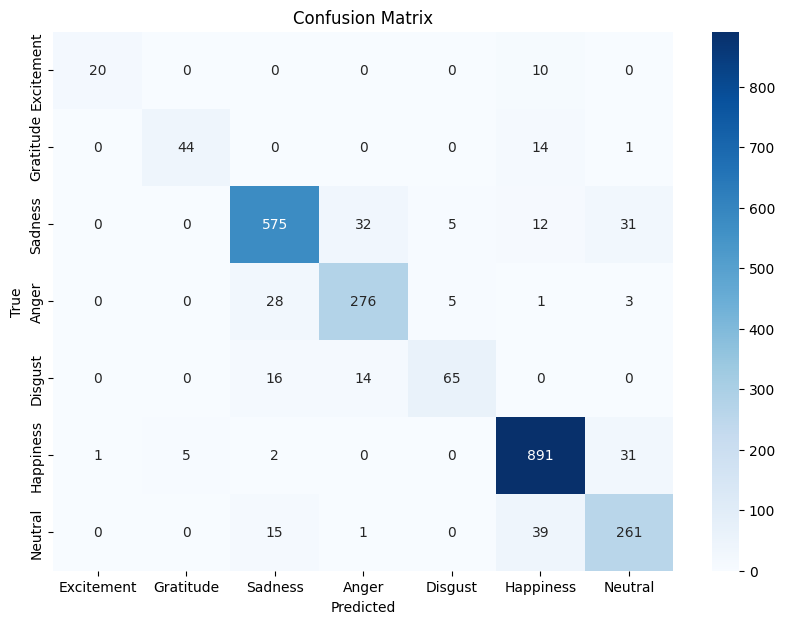

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Basic metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (weighted):", precision_score(y_true, y_pred, average='weighted'))
print("Recall (weighted):", recall_score(y_true, y_pred, average='weighted'))
print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(set(y_true)))
print(cm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(set(y_true)), yticklabels=list(set(y_true)), cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()